In [1]:
# %cd ../src
# %ls

this version supports over damped and underdamped dynamics

In [2]:
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as random
import flax
from flax import linen as nn
import optax

import time

import os
import pickle

import matplotlib.pyplot as plt

from torch.utils import data
from torch.utils.data import Dataset

print("the device used is", jax.devices(), jax.default_backend())
print(jax.device_count())

/home/roland/miniconda3/envs/my_diffusion/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/roland/miniconda3/envs/my_diffusion/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


the device used is [gpu(id=0)] gpu
1


# Dataloader and metaparameters

In [3]:
seed = 0
key = random.PRNGKey(seed)
rng = key
batch_size = 512
intermediate_embeding_time_dimension = 128
intermediate_features_embedding = 128
# epsilon = 0.01 # smallest time considered
num_timesteps = 1000

dimension = 2
T_max = 1.0

num_training_iterations = 40_000
ema_rate = 0.99

In [4]:
def generateBatchPoints(key, distribution = 'plus_sign', batch_size=batch_size) :
    if distribution == 'spiral' :
        key1, key2 = random.split(key)
        radius = random.uniform(key1, shape = (batch_size,1) , minval= 0., maxval= 1.)**.5
        noise = 0.01*random.normal(key2, shape = (batch_size,2))
        angle = 10*radius # angle from the first axis
        positions = jnp.concatenate( (radius*jnp.cos(angle),radius*jnp.sin(angle)), axis=1  ) + noise
    
    if distribution == 'plus_sign' :
        key1, key2 = random.split(key)
        radius = random.uniform(key1, shape = (batch_size,1) , minval= -1., maxval= 1.)
        axis = random.randint(key2, shape  = (batch_size,1), minval=0, maxval=2)
        positions = jnp.concatenate( (radius*axis,radius*(1 - axis)), axis=1  )

    return(positions[...,None])

class distribution_dataset(Dataset):
    def __init__(self, key = random.PRNGKey(seed)) : 

        self.points = generateBatchPoints(key, distribution = 'spiral', batch_size = batch_size*50 )

    def __len__(self):
        return self.points.shape[0]//batch_size 

    def __getitem__(self, idx):
        return( self.points[ idx*batch_size:(idx+1)*batch_size , ...])
    
    

In [5]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

class NumpyLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1,
                  shuffle=False, sampler=None,
                  batch_sampler=None, num_workers=0,
                  pin_memory=False, drop_last=False,
                  timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn)

In [6]:
rng , subkey = random.split(key)
trainset = distribution_dataset(subkey)
train_dataloader = NumpyLoader(trainset, batch_size=1, shuffle=True)

## useful functions

In [7]:
beta = 5.
M = 1.
gamma = 0.1
Gamma = 2*M**0.5 # is free from constraints
BETA = lambda t : t*beta
Sigma_xx_0 = 0.
Sigma_vv_0 = gamma*M
Sigma_xx = lambda t : (Sigma_xx_0 + jnp.exp(4*BETA(t)/Gamma) - 1 + 4*BETA(t)/Gamma*(Sigma_xx_0 - 1) + 4*(BETA(t)/Gamma)**2*(Sigma_xx_0 - 2) + 16*BETA(t)**2/Gamma**4*Sigma_vv_0)*jnp.exp(-4*BETA(t)/Gamma)
Sigma_xv = lambda t : (-BETA(t)*Sigma_xx_0 + 4*BETA(t)/Gamma**2*Sigma_vv_0 - 2*BETA(t)**2/Gamma*(Sigma_xx_0 - 2) - 8*BETA(t)**2/Gamma**3*Sigma_vv_0)*jnp.exp(-4*BETA(t)/Gamma)
Sigma_vv = lambda t : (Gamma**2/4*(jnp.exp(4*BETA(t)/Gamma) - 1) + BETA(t)*Gamma + Sigma_vv_0*(1 + 4*(BETA(t)/Gamma)**2 - 4*BETA(t)/Gamma) + BETA(t)**2*(Sigma_xx_0 - 2) )*jnp.exp(-4*BETA(t)/Gamma)

l_HSM = lambda t : jnp.sqrt( Sigma_xx(t)/(Sigma_xx(t)*Sigma_vv(t) - Sigma_xv(t)**2) )

L_Cholesky = lambda t : jnp.array([ [jnp.sqrt(Sigma_xx(t)) , jnp.zeros( t.shape ) ] , [ Sigma_xv(t)/jnp.sqrt(Sigma_xx(t)) , jnp.sqrt( (Sigma_xx(t)*Sigma_vv(t) - Sigma_xv(t)**2)/Sigma_xx(t) ) ]]).transpose((2,0,1))

# mu for DSM
# def mu(t,x_0,v_0) :
#     return jnp.concatenate([ 2*BETA(t)/Gamma*x_0 + 4*BETA(t)/Gamma**2*v_0 + x_0 , -BETA(t)*x_0 - 2*BETA(t)/Gamma*v_0 + v_0 ], axis = -1 )*jnp.exp(-2*BETA(t)/Gamma)

# mu for HSM (v_0 = 0)
def mu_HSM(t_batch,x_0_batch) :
    batch_size = x_0_batch.shape[0]
    x_0 = x_0_batch
    t = t_batch.flatten()

    # shapes give (2, batch) (batch, dim,1) (batch)  -> (batch, 2, dim) 
    return jnp.array([ 2*BETA(t)/Gamma + 1 , -BETA(t) ]).T.reshape((batch_size,2,1))*x_0.reshape((batch_size,1,dimension))*jnp.exp(-2*BETA(t)/Gamma).reshape((batch_size,1,1))


In [8]:
# test 
batch = jnp.ones((batch_size,2,1))
t_batch = jnp.ones((batch_size,))

print(mu_HSM(t_batch, batch).shape)

print(L_Cholesky(t_batch).shape)

(512, 2, 2)
(512, 2, 2)


In [9]:
L_Cholesky(jnp.array([10]))

Array([[[inf,  0.],
        [ 0., nan]]], dtype=float32)

In [10]:
@jax.jit
def PositionalEncoding(time_indices, embed_dimension = intermediate_embeding_time_dimension) :
    """ 
    - time_indices : shape (batch_size,) , should be int between 0 and num_timesteps
    - embed_dimension : dimension of the embeded time, *must be even* for definition of k in the function !
    """ 
     
    magic_number = 1000 # custom magic number addapted for embed_dimension = 128 
    times = time_indices.reshape( (1,-1) )
    k = jnp.arange( 0, embed_dimension//2 ).reshape((-1,1))

    ### might not be the most elegant way to do this ? :
    embedding = jnp.array([ jnp.cos( times/(magic_number**(2.*k/embed_dimension)) ) , jnp.sin( times/(magic_number**(2.*k/embed_dimension)) ) ])
    # embedding shape is (2, embed_dimension/2, batch_size) and should become (batch_size, embed_dim)
    embedding = jnp.transpose(embedding, (2,1,0))
    embedding = embedding.reshape((-1, embed_dimension ))
    ###

    return(embedding)


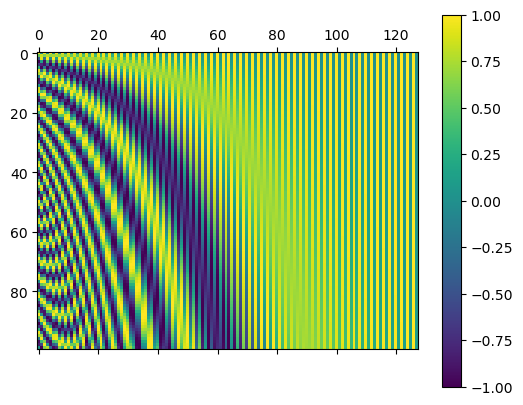

In [11]:
# test 
embedded = PositionalEncoding(jnp.arange(0,100))

plt.matshow(embedded)
plt.colorbar()
plt.show()

In [12]:
class batch_MLP_bloc(nn.Module):                    # create a Flax Module dataclass
  out_dims: int

  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(128)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(128)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(128)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(self.out_dims)(x)       # shape inference
    return x


In [13]:
batch_MLP_embedding_layers = batch_MLP_bloc(out_dims= intermediate_features_embedding) 
batch_MLP_final_layers = batch_MLP_bloc(out_dims= 2)

def generateParameters(key):

    key, key1, key2, key3, key4 = random.split(key,5)

    # useless to put batch_size instead of '1'
    typical_batch = jnp.empty((batch_size, 2,1))
    typical_time_batch = jnp.empty((batch_size,intermediate_embeding_time_dimension))
    typical_embedded_batch = jnp.empty((batch_size, 3*intermediate_features_embedding))
    
    params_times = batch_MLP_embedding_layers.init(key1, typical_time_batch)
    params_positions = batch_MLP_embedding_layers.init(key2, typical_batch)
    params_velocities =  batch_MLP_embedding_layers.init(key3, typical_batch)
    params_global = batch_MLP_final_layers.init(key4, typical_embedded_batch)
    

    parameters = { 'params_times' : params_times,
                'params_positions' : params_positions,
                'params_velocities' : params_velocities,
                'params_global' : params_global }
    
    return(key,parameters)

In [14]:
batch_MLP_embedding_layers = batch_MLP_bloc(out_dims= intermediate_features_embedding) 
batch_MLP_final_layers = batch_MLP_bloc(out_dims= 2)

@jax.jit
def alpha_model(parameters,batch_positions, batch_velocities, time_indices) :

    """
    input :
    - parameters : a dictionary with three keys 'params_times', 'params_positions', 'params_vitesses', 'params_global' for the respectives MLP
    - batch : positions batch shape (batch_size, 2, 1)
    - time_indices : shape (batch_size,) should be integers (float of int)
    output :
    - shape (batch_size,2,1)
    """
    time_embedding = PositionalEncoding(time_indices)
    params_times = parameters['params_times']
    params_positions = parameters['params_positions']
    params_velocities = parameters['params_velocities']
    params_global = parameters['params_global']

    time_embedding = batch_MLP_embedding_layers.apply( params_times, time_embedding)
    position_embedding = batch_MLP_embedding_layers.apply( params_positions, batch_positions)
    velocity_embedding = batch_MLP_embedding_layers.apply( params_velocities, batch_velocities)
    
    global_embedding = jnp.concatenate( (time_embedding, position_embedding, velocity_embedding) , axis = 1)

    result = batch_MLP_final_layers.apply( params_global, global_embedding )[:,:,None]

    return(result)

In [15]:
# test 
key, parameters = generateParameters(key)

times = jnp.ones((batch_size,))
batch = random.normal(key, (batch_size,2,1) )
batch_velocities = random.normal(key, (batch_size,2,1) )
result = alpha_model(parameters, batch, batch_velocities, times )
print(result.shape)

(512, 2, 1)


In [16]:
def timeIndeces2RealTime(time_indices ) :
    return( time_indices *1.0/num_timesteps)

@jax.jit
def batch_loss(parameters,batch, key) :
    """
    input :
    - parameters : a dictionary with three keys 'params_times', 'params_positions', 'params_vitesses', 'params_global' for the respectives MLP
    - batch : positions batch shape (batch_size, 2, 1)
    """
    key, key2, key3, key4 = random.split(key,4)

    # sampling times
    time_indices = random.randint(key2, shape = (batch_size,), minval= 1, maxval= num_timesteps)
    real_time_batch = timeIndeces2RealTime(time_indices )

    epsilon = random.normal(key3, shape = (batch_size,dimension, 2)) 

    batch_global = mu_HSM(real_time_batch, batch) + (L_Cholesky(real_time_batch)[:,None,:,:]@epsilon[...,None])[...,0].transpose( (0,2,1) ) # shape (batch_size, 2,dim)
    batch_positions = batch_global[:,0,:]
    batch_velocities = batch_global[:,1,:]

    loss = jnp.mean(( epsilon[:,:,1].squeeze() -  alpha_model(parameters,batch_positions, batch_velocities, time_indices).squeeze()  )**2 )
    return(loss)
    

In [17]:
# test 
real_time_batch = jnp.ones((batch_size,))

epsilon = random.normal(key, shape = (batch_size, 2, dimension))

batch_global = L_Cholesky(real_time_batch)@epsilon
print(batch_size)
print(L_Cholesky(real_time_batch).shape)
print(epsilon.shape)
print(batch_global.shape)

512
(512, 2, 2)
(512, 2, 2)
(512, 2, 2)


In [18]:
def train_or_retrieve_model(key, savingFileName = "second_order_parameters_v2.npy") :

    if os.path.isfile(savingFileName) :
        with open(savingFileName, 'rb') as file:
            parameters = pickle.load(file)
    else :
        key, parameters = generateParameters(key)

        learning_rate = 0.002
        optimizer = optax.adam(learning_rate)
        opt_state = optimizer.init(parameters)

        loss_cache = []
        i = 0
        while i < num_training_iterations :

            for batch in train_dataloader :
                batch = batch[0]

                key = random.split(key, 1)[0]
                value, grads = jax.value_and_grad(batch_loss)(parameters, batch, key)
                loss_cache.append(value)
                if i%500 == 0 :
                    print( "step :", str(i), "   -   loss :", str(np.mean(loss_cache)))
                    loss_cache = [] 
                updates, opt_state = optimizer.update(grads, opt_state)
                parameters = optax.apply_updates(parameters, updates)
                i+=1

        with open(savingFileName, 'wb') as file:
            pickle.dump(parameters, file)
    return(parameters)

In [19]:
parameters = train_or_retrieve_model(key)

step : 0    -   loss : 0.95373565
step : 500    -   loss : 0.12921369
step : 1000    -   loss : 0.11766307
step : 1500    -   loss : 0.10940604
step : 2000    -   loss : 0.10726746
step : 2500    -   loss : 0.10528763
step : 3000    -   loss : 0.104808256
step : 3500    -   loss : 0.10292766
step : 4000    -   loss : 0.10246177
step : 4500    -   loss : 0.10034938
step : 5000    -   loss : 0.101086326
step : 5500    -   loss : 0.09903813
step : 6000    -   loss : 0.1002999
step : 6500    -   loss : 0.09951404
step : 7000    -   loss : 0.09930691
step : 7500    -   loss : 0.099614054
step : 8000    -   loss : 0.09871545
step : 8500    -   loss : 0.098723605
step : 9000    -   loss : 0.09889267
step : 9500    -   loss : 0.09796033
step : 10000    -   loss : 0.09809286
step : 10500    -   loss : 0.09765819
step : 11000    -   loss : 0.09825076
step : 11500    -   loss : 0.09748677
step : 12000    -   loss : 0.09684981
step : 12500    -   loss : 0.09742996
step : 13000    -   loss : 0.0968

In [20]:
def score(parameters,batch_positions, batch_velocities, time_indices) :
    real_time_batch = timeIndeces2RealTime(time_indices )
    return( -l_HSM(real_time_batch)[:,None,None]*alpha_model(parameters,batch_positions, batch_velocities, time_indices) )

In [21]:
# test 
batch_positions = jnp.zeros((batch_size,2,1))
batch_velocities = jnp.zeros((batch_size,2,1))
time_indices = jnp.ones((batch_size,))

sco = score(parameters,batch_positions, batch_velocities, time_indices)
print(sco.shape)

(512, 2, 1)


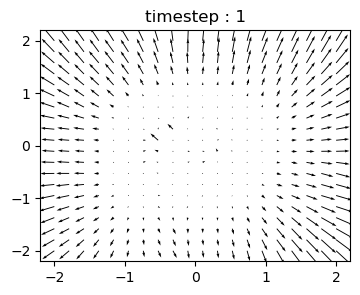

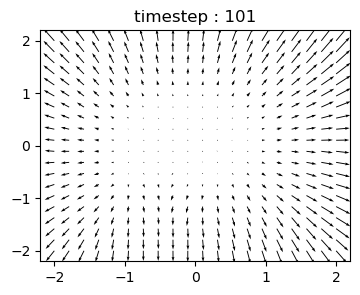

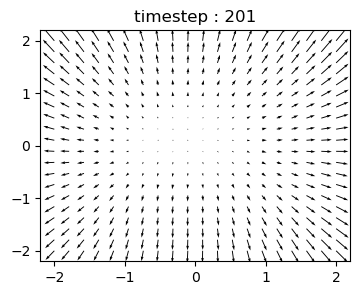

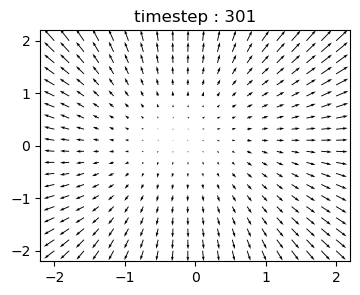

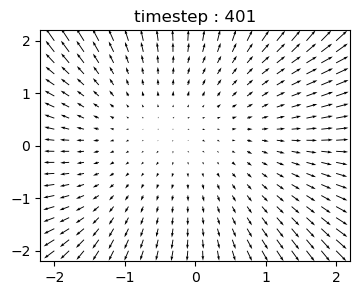

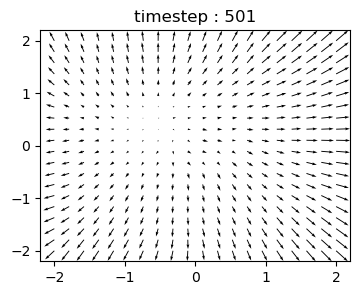

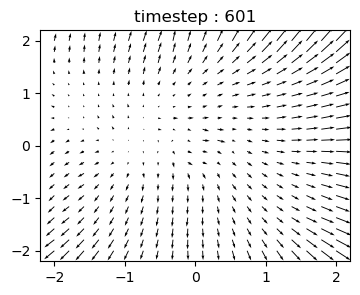

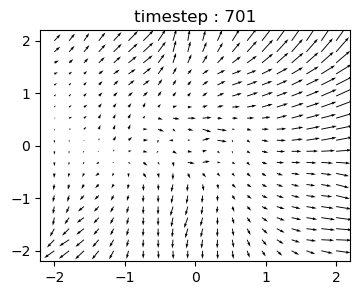

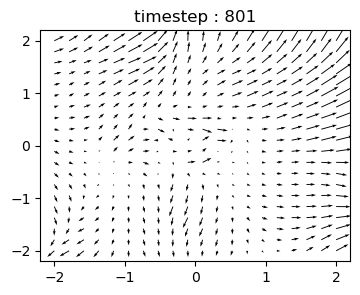

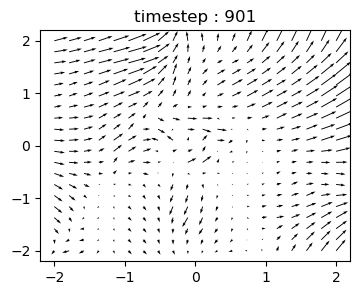

In [22]:
# test 
batch_velocities = jnp.zeros((batch_size, 2, 1))
# Batch_size must be superior to 400 for this test
for timestep in range(1,num_timesteps,100) :
    x,y = np.meshgrid(np.linspace(-2,2,20),np.linspace(-2,2,20))
    X = x.flatten()
    Y = y.flatten()
    batch = np.zeros((batch_size,2,1))
    batch[:400] = np.concatenate( [X[:,None],Y[:,None]], axis = 1)[...,None]
    time_indices = np.ones((batch_size,))*timestep
    scores = score(parameters, batch, batch_velocities, time_indices)[:400]
    u,v = scores[:,0,0], scores[:,1,0]
    plt.figure(figsize=(4,3))
    plt.quiver(x,y,u,v)
    plt.title( "timestep : " + str(timestep))
    plt.show()

In [23]:
@jax.jit
def deterministic_predictor(batch, i, step_size, parameters ) :
    """ 
    - batch : shape (batch_size, 2, dim, 1)
    - i : integer
    - step_size : shape (batch_size,)
    - parameters : dict of parameters for score(...)
    """
    batch_positions = batch[:,0,...] 
    batch_velocities = batch[:,1,...] 
    batch_positions_updated = batch_positions -1.0/M*batch_velocities*beta*step_size[:,None,None] 
    batch_velocities_updated = batch_velocities + batch_positions*beta*step_size[:,None,None]  + 0 + \
                    2*Gamma*( score(parameters, batch_positions, batch_velocities, time_indices[i+1]) + batch_velocities/M )*beta*step_size[:,None,None]

    batch = jnp.concatenate( ( batch_positions_updated[:,None,:,:], batch_velocities_updated[:,None,:,:]), axis = 1)
    return(batch)

In [24]:
def timeSteps2stepSize(num_timesteps : int, batch_size : int):
    """ 
    - num_timesteps : int 
    - batch_size : int

    returns :
    - stepSize : shape (num_timesteps, batch_size) 
    """ 
    stepSize = jnp.ones((batch_size,num_timesteps)).T*1.0/num_timesteps
    return(stepSize)

In [25]:
time_indices = jnp.array( list(range(num_timesteps))*batch_size).reshape(batch_size,num_timesteps).T

def generate_deterministic_batch(key, parameters, time_indices = time_indices) :
    
    """ 
    - key : PRNG key
    - time_indices : shape (num_timsteps, batch_size) , timsteps are ordered from smallest to biggest
    """

    key1, key = random.split(key)
    
    stepSize = timeSteps2stepSize(num_timesteps, batch_size)
    batch = random.normal(key1, shape = (batch_size, 2, 2,1))*jnp.array([1,M]).reshape((1,-1,1,1)) # prior distribution
    for i in range(num_timesteps- 2, 0, -1) :

        batch = deterministic_predictor( batch, i, stepSize[i], parameters )
        batch_positions = batch[:,0,:,:]
        ### test 
        if i%100 == 1 :
          plt.figure(figsize = (4,3))
          plt.scatter(batch_positions[:,0,0], batch_positions[:,1,0], s = 0.2, alpha = 0.7)
          plt.title("step : " + str(i))
          plt.show()
        ###

    return(batch)

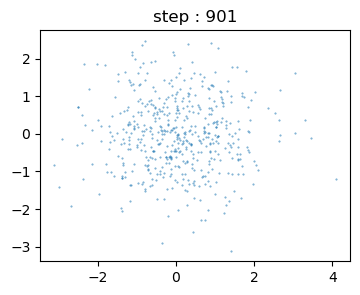

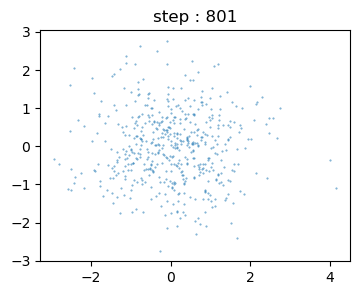

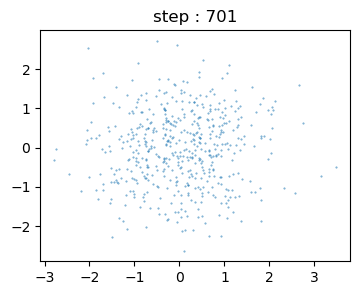

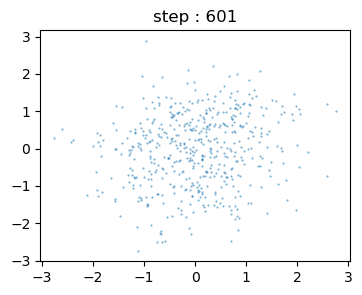

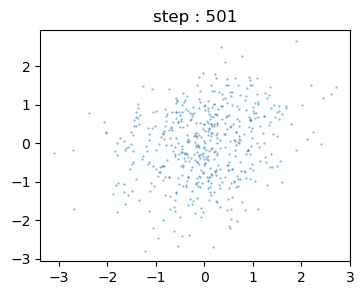

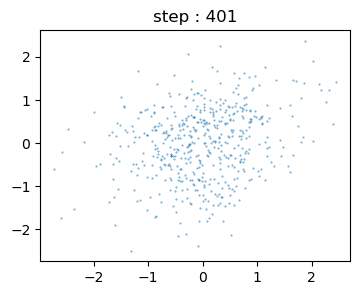

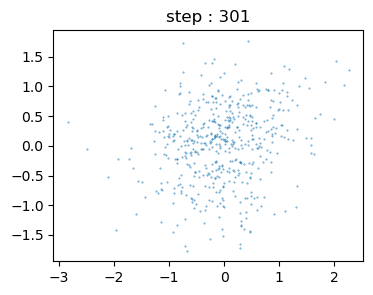

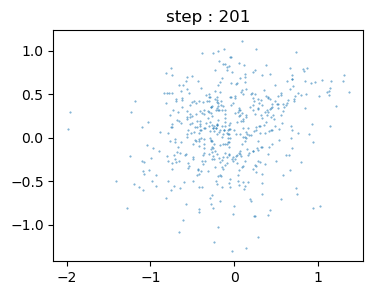

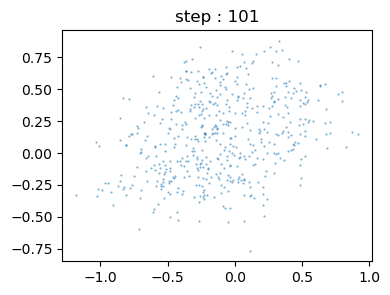

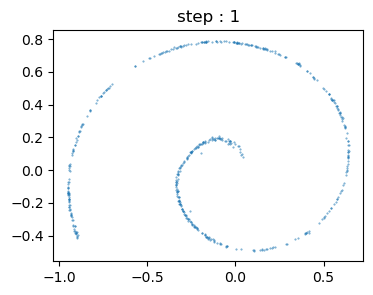

In [26]:
result = generate_deterministic_batch(key, parameters, time_indices = time_indices)

In [27]:
@jax.jit
def predictor(batch, i, step_size, parameters, key ) :
    """ 
    - batch : shape (batch_size, 2, dim, 1)
    - i : integer
    - step_size : shape (batch_size,)
    - parameters : dict of parameters for score(...)
    """
    key, subkey = random.split(key)
    
    batch_positions = batch[:,0,...] 
    batch_velocities = batch[:,1,...] 
    eps = random.normal(subkey, shape = batch_velocities.shape)*jnp.sqrt(step_size[:,None,None])
    print("update 1 ", -1.0/M*batch_velocities*beta*step_size[:,None,None]  )
    print( "update 2 ", batch_positions*beta*step_size[:,None,None]  + \
                    -Gamma/M*batch_velocities*beta*step_size[:,None,None] + jnp.sqrt(2*Gamma*beta)*eps + \
                    2*Gamma*( score(parameters, batch_positions, batch_velocities, time_indices[i+1]) + \
                    batch_velocities/M )*beta*step_size[:,None,None] )
    batch_positions_updated = batch_positions -1.0/M*batch_velocities*beta*step_size[:,None,None] 
    batch_velocities_updated = batch_velocities + batch_positions*beta*step_size[:,None,None]  + \
                    -Gamma/M*batch_velocities*beta*step_size[:,None,None] + jnp.sqrt(2*Gamma*beta)*eps + \
                    2*Gamma*( score(parameters, batch_positions, batch_velocities, time_indices[i+1]) + \
                    batch_velocities/M )*beta*step_size[:,None,None]

    batch = jnp.concatenate( ( batch_positions_updated[:,None,:,:], batch_velocities_updated[:,None,:,:]), axis = 1)
    return(key, batch)

In [28]:
time_indices = jnp.array( list(range(num_timesteps))*batch_size).reshape(batch_size,num_timesteps).T

def generate_batch(key, parameters, time_indices = time_indices) :
    
    """ 
    - key : PRNG key
    - time_indices : shape (num_timsteps, batch_size) , timsteps are ordered from smallest to biggest
    """

    key1, key = random.split(key)
    
    stepSize = timeSteps2stepSize(num_timesteps, batch_size)
    batch = random.normal(key1, shape = (batch_size, 2, 2,1))*jnp.array([1,M]).reshape((1,-1,1,1)) # prior distribution
    for i in range(num_timesteps- 2, 0, -1) :

        key, batch = predictor( batch, i, stepSize[i], parameters, key)
        batch_positions = batch[:,0,:,:]
        ### test 
        if i%100 == 1 :
          plt.figure(figsize = (4,3))
          plt.scatter(batch_positions[:,0,0], batch_positions[:,1,0], s = 0.2, alpha = 0.7)
          plt.title("step : " + str(i))
          plt.show()
        ###

    return(batch)

update 1  [[[-0.01050471]
  [-0.00453585]]

 [[ 0.00023108]
  [-0.0016732 ]]

 [[ 0.00921764]
  [-0.00584227]]

 ...

 [[-0.00263588]
  [-0.00191902]]

 [[-0.0013722 ]
  [ 0.00417578]]

 [[ 0.00013532]
  [ 0.00623332]]]
update 2  [[[-0.44303674]
  [-0.01828462]]

 [[-0.14752546]
  [-0.04253034]]

 [[ 0.04846872]
  [ 0.09453796]]

 ...

 [[ 0.02513722]
  [-0.2126198 ]]

 [[-0.07857939]
  [-0.09987278]]

 [[ 0.02105497]
  [-0.04253548]]]
update 1  [[[-8.2895225e-03]
  [-4.4444222e-03]]

 [[ 9.6870388e-04]
  [-1.4605487e-03]]

 [[ 8.9752981e-03]
  [-6.3149622e-03]]

 ...

 [[-2.7615672e-03]
  [-8.5592328e-04]]

 [[-9.7929896e-04]
  [ 4.6751439e-03]]

 [[ 3.0043984e-05]
  [ 6.4459983e-03]]]
update 2  [[[-0.06837193]
  [-0.12857273]]

 [[-0.11350368]
  [ 0.32102638]]

 [[-0.19949566]
  [-0.12464266]]

 ...

 [[ 0.19619492]
  [-0.09997011]]

 [[ 0.00064976]
  [-0.04581647]]

 [[ 0.27993116]
  [-0.22660485]]]
update 1  [[[-0.00794766]
  [-0.00380156]]

 [[ 0.00153622]
  [-0.00306568]]

 [[ 0.

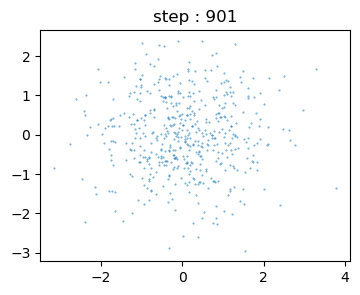

update 1  [[[-0.00478693]
  [-0.00233995]]

 [[ 0.00560798]
  [ 0.00677009]]

 [[-0.00279094]
  [-0.00101238]]

 ...

 [[-0.00571163]
  [ 0.00189673]]

 [[ 0.00268157]
  [-0.00113477]]

 [[ 0.01262698]
  [-0.00022251]]]
update 2  [[[-0.02661397]
  [ 0.20790085]]

 [[ 0.01811983]
  [ 0.26216602]]

 [[ 0.07760502]
  [-0.07851651]]

 ...

 [[ 0.09829005]
  [-0.05953205]]

 [[-0.3085064 ]
  [ 0.1086733 ]]

 [[-0.0452063 ]
  [ 0.06666616]]]
update 1  [[[-0.00465386]
  [-0.00337945]]

 [[ 0.00551738]
  [ 0.00545926]]

 [[-0.00317896]
  [-0.00061979]]

 ...

 [[-0.00620308]
  [ 0.00219439]]

 [[ 0.0042241 ]
  [-0.00167814]]

 [[ 0.01285301]
  [-0.00055584]]]
update 2  [[[ 0.08474112]
  [-0.14090043]]

 [[ 0.05098521]
  [ 0.08133908]]

 [[ 0.09258532]
  [-0.10163721]]

 ...

 [[ 0.05733655]
  [ 0.12292369]]

 [[ 0.00964953]
  [ 0.16442959]]

 [[ 0.0363945 ]
  [-0.20122063]]]
update 1  [[[-0.00507756]
  [-0.00267495]]

 [[ 0.00526245]
  [ 0.00505257]]

 [[-0.00364189]
  [-0.00011161]]

 ...

 [

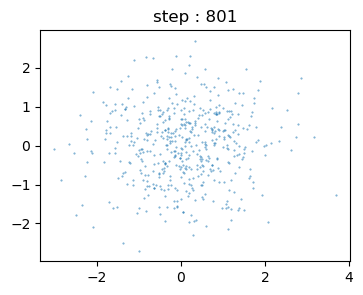

update 1  [[[-0.00912942]
  [ 0.00632559]]

 [[ 0.00382991]
  [ 0.00445487]]

 [[-0.00158817]
  [ 0.00322917]]

 ...

 [[-0.0009037 ]
  [-0.00089127]]

 [[ 0.00279232]
  [-0.00698053]]

 [[-0.00162058]
  [-0.00147257]]]
update 2  [[[-0.13441189]
  [-0.25936395]]

 [[-0.25904363]
  [ 0.11410489]]

 [[-0.1161733 ]
  [ 0.02026932]]

 ...

 [[ 0.17587386]
  [ 0.20384444]]

 [[-0.06410177]
  [-0.15774876]]

 [[ 0.11119065]
  [ 0.10793188]]]
update 1  [[[-0.00845736]
  [ 0.00762241]]

 [[ 0.00512513]
  [ 0.00388435]]

 [[-0.0010073 ]
  [ 0.00312782]]

 ...

 [[-0.00178307]
  [-0.00191049]]

 [[ 0.00311283]
  [-0.00619179]]

 [[-0.00217654]
  [-0.00201222]]]
update 2  [[[-0.12013762]
  [ 0.2559444 ]]

 [[ 0.08127439]
  [-0.13073716]]

 [[-0.04849736]
  [-0.07982107]]

 ...

 [[-0.02516788]
  [-0.01666118]]

 [[ 0.09291643]
  [ 0.09287219]]

 [[-0.03988655]
  [-0.15587918]]]
update 1  [[[-0.00785667]
  [ 0.00634268]]

 [[ 0.00471876]
  [ 0.00453804]]

 [[-0.00076481]
  [ 0.00352693]]

 ...

 [

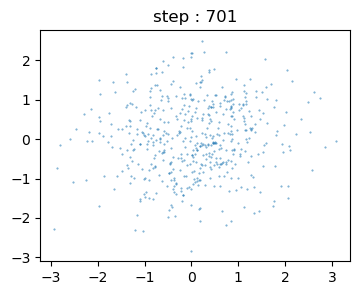

update 1  [[[ 0.00802617]
  [ 0.00166809]]

 [[ 0.00437344]
  [ 0.00924888]]

 [[-0.00983857]
  [-0.00079399]]

 ...

 [[ 0.00543003]
  [ 0.00048684]]

 [[-0.00132373]
  [-0.00907279]]

 [[ 0.00426255]
  [-0.00146084]]]
update 2  [[[-0.04948397]
  [-0.12811553]]

 [[-0.0042602 ]
  [ 0.16150123]]

 [[-0.19032884]
  [ 0.1382786 ]]

 ...

 [[-0.07790368]
  [-0.06964481]]

 [[ 0.13965347]
  [-0.05823115]]

 [[ 0.08134501]
  [ 0.0288214 ]]]
update 1  [[[ 0.00827359]
  [ 0.00230867]]

 [[ 0.00439474]
  [ 0.00844137]]

 [[-0.00888693]
  [-0.00148538]]

 ...

 [[ 0.00581955]
  [ 0.00083507]]

 [[-0.00202199]
  [-0.00878163]]

 [[ 0.00385583]
  [-0.00160495]]]
update 2  [[[ 0.0767766 ]
  [-0.00975236]]

 [[ 0.13911094]
  [ 0.18000408]]

 [[ 0.0311128 ]
  [-0.01695164]]

 ...

 [[ 0.01972113]
  [ 0.03146565]]

 [[-0.06275146]
  [ 0.01488246]]

 [[-0.01712383]
  [-0.08297034]]]
update 1  [[[ 0.00788971]
  [ 0.00235743]]

 [[ 0.00369919]
  [ 0.00754135]]

 [[-0.00904249]
  [-0.00140062]]

 ...

 [

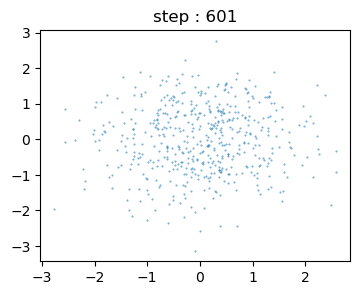

update 1  [[[ 0.00580854]
  [-0.00333146]]

 [[-0.0009195 ]
  [-0.0038317 ]]

 [[ 0.00566124]
  [ 0.00124091]]

 ...

 [[ 0.00326309]
  [-0.00031845]]

 [[-0.00031569]
  [-0.00391014]]

 [[-0.00447681]
  [-0.0055407 ]]]
update 2  [[[-0.21065012]
  [-0.18734987]]

 [[ 0.06161264]
  [-0.13980043]]

 [[ 0.20239934]
  [-0.12149341]]

 ...

 [[ 0.15630166]
  [-0.1442537 ]]

 [[ 0.01551173]
  [-0.03255389]]

 [[-0.03011619]
  [ 0.07922761]]]
update 1  [[[ 0.00686179]
  [-0.00239471]]

 [[-0.00122757]
  [-0.0031327 ]]

 [[ 0.00464925]
  [ 0.00184838]]

 ...

 [[ 0.00248158]
  [ 0.00040282]]

 [[-0.00039325]
  [-0.00374737]]

 [[-0.00432623]
  [-0.00593684]]]
update 2  [[[ 0.26674235]
  [ 0.04171554]]

 [[ 0.1141894 ]
  [ 0.00121143]]

 [[-0.07242363]
  [ 0.21571015]]

 ...

 [[-0.03183035]
  [ 0.03343959]]

 [[-0.06431831]
  [-0.03753176]]

 [[ 0.08186185]
  [ 0.00443839]]]
update 1  [[[ 5.5280793e-03]
  [-2.6032927e-03]]

 [[-1.7985121e-03]
  [-3.1387559e-03]]

 [[ 5.0113662e-03]
  [ 7.69828

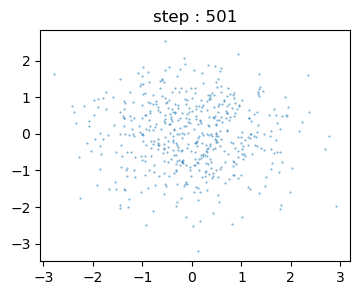

update 1  [[[ 0.00385171]
  [ 0.00246525]]

 [[-0.00654526]
  [-0.0106879 ]]

 [[ 0.00591578]
  [-0.00457583]]

 ...

 [[ 0.00044809]
  [ 0.00118693]]

 [[ 0.00561041]
  [ 0.00707009]]

 [[-0.00146704]
  [ 0.00143897]]]
update 2  [[[-0.17672518]
  [-0.44316152]]

 [[-0.02063284]
  [-0.06283563]]

 [[-0.07770216]
  [ 0.16517124]]

 ...

 [[ 0.00374808]
  [-0.05614497]]

 [[-0.02636816]
  [-0.21479297]]

 [[ 0.06640273]
  [ 0.12690058]]]
update 1  [[[ 0.00473534]
  [ 0.00468106]]

 [[-0.0064421 ]
  [-0.01037372]]

 [[ 0.00630429]
  [-0.00540168]]

 ...

 [[ 0.00042935]
  [ 0.00146766]]

 [[ 0.00574225]
  [ 0.00814405]]

 [[-0.00179906]
  [ 0.00080446]]]
update 2  [[[-0.05831182]
  [ 0.02383369]]

 [[-0.00916469]
  [-0.06460326]]

 [[ 0.00078988]
  [-0.18232633]]

 ...

 [[-0.02666771]
  [-0.24556136]]

 [[-0.0349709 ]
  [-0.0307963 ]]

 [[ 0.04878538]
  [ 0.00257316]]]
update 1  [[[ 0.0050269 ]
  [ 0.00456189]]

 [[-0.00639628]
  [-0.0100507 ]]

 [[ 0.00630034]
  [-0.00449005]]

 ...

 [

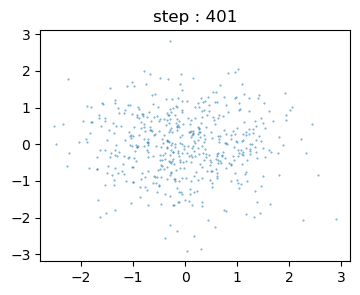

update 1  [[[ 2.2663870e-03]
  [ 4.2136242e-03]]

 [[-4.5400742e-03]
  [-6.3440595e-03]]

 [[ 2.7372804e-03]
  [ 3.6508366e-03]]

 ...

 [[-6.9796080e-03]
  [ 8.3685583e-03]]

 [[ 4.8384839e-03]
  [ 3.6867249e-03]]

 [[-5.1117982e-05]
  [ 4.4881643e-05]]]
update 2  [[[ 0.11683278]
  [-0.07505591]]

 [[-0.23508668]
  [ 0.04778063]]

 [[ 0.05846252]
  [-0.0268708 ]]

 ...

 [[-0.07187827]
  [-0.13583432]]

 [[-0.07865345]
  [ 0.09233137]]

 [[ 0.11647248]
  [-0.00574001]]]
update 1  [[[ 1.6822231e-03]
  [ 4.5889039e-03]]

 [[-3.3646405e-03]
  [-6.5829619e-03]]

 [[ 2.4449681e-03]
  [ 3.7851906e-03]]

 ...

 [[-6.6202166e-03]
  [ 9.0477299e-03]]

 [[ 5.2317516e-03]
  [ 3.2250679e-03]]

 [[-6.3348032e-04]
  [ 7.3581708e-05]]]
update 2  [[[ 0.00662729]
  [-0.06339442]]

 [[-0.16365667]
  [-0.11038599]]

 [[ 0.05273202]
  [-0.03034258]]

 ...

 [[-0.17277116]
  [-0.02282872]]

 [[-0.03513236]
  [ 0.09746773]]

 [[ 0.08187005]
  [-0.03227698]]]
update 1  [[[ 0.00164909]
  [ 0.00490588]]

 [[-

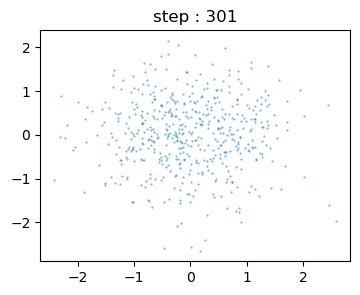

update 1  [[[-0.00281781]
  [-0.00510286]]

 [[-0.00563902]
  [-0.00664083]]

 [[ 0.00115999]
  [ 0.00663473]]

 ...

 [[-0.0071895 ]
  [-0.00163226]]

 [[-0.00197016]
  [ 0.00611391]]

 [[-0.00844238]
  [ 0.0032298 ]]]
update 2  [[[ 0.15658121]
  [-0.07532304]]

 [[-0.08692101]
  [ 0.13410622]]

 [[ 0.07951344]
  [ 0.01653286]]

 ...

 [[ 0.24973051]
  [ 0.11533437]]

 [[ 0.05230781]
  [ 0.00937039]]

 [[ 0.04027509]
  [-0.10026338]]]
update 1  [[[-0.00360071]
  [-0.00472625]]

 [[-0.00520441]
  [-0.00731136]]

 [[ 0.00076243]
  [ 0.00655206]]

 ...

 [[-0.00843815]
  [-0.00220893]]

 [[-0.0022317 ]
  [ 0.00606706]]

 [[-0.00864375]
  [ 0.00373112]]]
update 2  [[[-0.07996256]
  [-0.02352132]]

 [[ 0.16509053]
  [ 0.22463338]]

 [[ 0.06732996]
  [-0.16986379]]

 ...

 [[ 0.11017449]
  [-0.104049  ]]

 [[ 0.16427931]
  [ 0.02292396]]

 [[-0.11334486]
  [-0.04428684]]]
update 1  [[[-0.0032009 ]
  [-0.00460864]]

 [[-0.00602987]
  [-0.00843453]]

 [[ 0.00042578]
  [ 0.00740138]]

 ...

 [

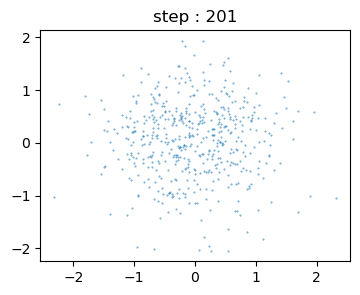

update 1  [[[-0.00737879]
  [-0.00689257]]

 [[ 0.00121168]
  [-0.00212296]]

 [[-0.00441013]
  [ 0.00465604]]

 ...

 [[ 0.00400826]
  [-0.0051024 ]]

 [[-0.00259126]
  [ 0.00072252]]

 [[-0.00393372]
  [-0.00355541]]]
update 2  [[[-0.05673117]
  [ 0.15567099]]

 [[ 0.1712587 ]
  [ 0.06792053]]

 [[-0.16035485]
  [-0.29721153]]

 ...

 [[-0.11866899]
  [-0.06730359]]

 [[-0.18076648]
  [ 0.06184195]]

 [[ 0.10349393]
  [-0.15010014]]]
update 1  [[[-0.00709513]
  [-0.00767093]]

 [[ 0.00035538]
  [-0.00246256]]

 [[-0.00360835]
  [ 0.0061421 ]]

 ...

 [[ 0.0046016 ]
  [-0.00476588]]

 [[-0.00168742]
  [ 0.00041331]]

 [[-0.00445118]
  [-0.00280491]]]
update 2  [[[-0.05964516]
  [ 0.071596  ]]

 [[ 0.08688302]
  [-0.16089176]]

 [[-0.04798433]
  [ 0.02333854]]

 ...

 [[ 0.04648601]
  [-0.12649588]]

 [[ 0.04686302]
  [ 0.15137212]]

 [[ 0.01828066]
  [-0.05772632]]]
update 1  [[[-6.7969081e-03]
  [-8.0289096e-03]]

 [[-7.9033081e-05]
  [-1.6581019e-03]]

 [[-3.3684326e-03]
  [ 6.02540

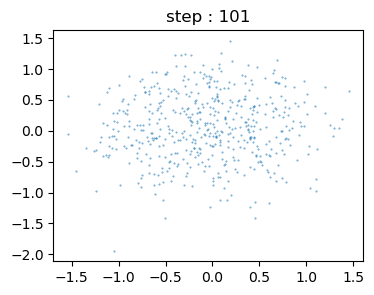

update 1  [[[-0.00418627]
  [-0.00439384]]

 [[ 0.00225669]
  [ 0.00078963]]

 [[-0.00178148]
  [ 0.00727388]]

 ...

 [[ 0.00308769]
  [-0.00643818]]

 [[ 0.00831659]
  [ 0.00550387]]

 [[-0.0010797 ]
  [ 0.00212381]]]
update 2  [[[ 0.14772706]
  [ 0.21350043]]

 [[-0.3406416 ]
  [ 0.1811068 ]]

 [[-0.02897907]
  [ 0.22496927]]

 ...

 [[-0.01323598]
  [-0.27931064]]

 [[ 0.08443008]
  [ 0.19120555]]

 [[-0.09194089]
  [-0.05783812]]]
update 1  [[[-0.00492491]
  [-0.00546134]]

 [[ 0.0039599 ]
  [-0.00011591]]

 [[-0.00163658]
  [ 0.00614904]]

 ...

 [[ 0.00315387]
  [-0.00504163]]

 [[ 0.00789444]
  [ 0.00454784]]

 [[-0.00061999]
  [ 0.002413  ]]]
update 2  [[[-0.1616349 ]
  [-0.09098963]]

 [[ 0.01906722]
  [ 0.05968893]]

 [[-0.15861347]
  [ 0.05262397]]

 ...

 [[-0.06487525]
  [ 0.00417169]]

 [[-0.01042818]
  [-0.25328192]]

 [[ 0.03055787]
  [ 0.03134696]]]
update 1  [[[-0.00411673]
  [-0.00500639]]

 [[ 0.00386456]
  [-0.00041435]]

 [[-0.00084351]
  [ 0.00588591]]

 ...

 [

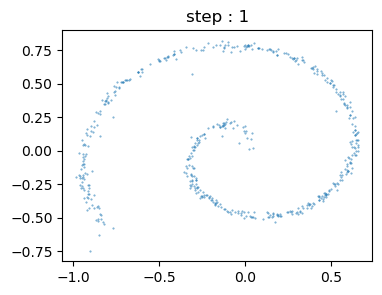

In [29]:
with jax.disable_jit() :
    result = generate_batch(key, parameters, time_indices = time_indices)